## 📊 Chess Evaluation
About Dataset
This is a dataset containing around 16 million chess positions with a Stockfish evaluation at depth 22. MIT license. Please help contribute using https://github.com/r2dev2bb8/ChessDataContributor. The Mac and Windows releases somewhat work. Linux has not been tested yet. The dataset will be updated around once a week.

In [1]:
%pip install kagglehub
import kagglehub

# Download latest version
path = kagglehub.dataset_download("ronakbadhe/chess-evaluations")

print("Path to dataset files:", path)

Note: you may need to restart the kernel to use updated packages.


100%|██████████| 200M/200M [00:09<00:00, 21.1MB/s] 

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/ronakbadhe/chess-evaluations/versions/5


## Chess Evaluation CNN (TensorFlow)

In [4]:
%pip install chess tensorflow pandas numpy
import tensorflow as tf
from tensorflow.keras import layers, Model, optimizers
import pandas as pd
import chess
import numpy as np

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 644.9/644.9 MB 4.9 MB/s eta 0:00:0000:0100:03
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.0/6.0 MB 25.3 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.7/4.7 MB 23.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 22.5 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.6/6.6 MB 19.7 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.5/4.5 MB 26.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 21.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.5/24.5 MB 22.6 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.1/5.1 MB 23.3 MB/s eta 0:00:0000:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 19/19 [tensorflow]9 [tensorflow]]data-server]
Note: you may need to restart the kernel to use updated packages.


2025-06-14 18:04:10.898956: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-06-14 18:04:10.926815: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-06-14 18:04:10.942882: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1749924250.975742   38426 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1749924250.981605   38426 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1749924251.000926   38426 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linkin

## Preprocessing
Converting FEN notation to tensor


In [7]:

from modules.ml_utils import fen_to_tensor

## Data loader + Label encoder

In [ ]:
# Load dataset from CSV
def load_data(csv_path,sample_size=1000):
    data = pd.read_csv(csv_path)
    data = data.sample(n=sample_size, random_state=42)
    boards, active_players, halfmove_clocks, evaluations = [], [], [], []
    for idx, row in data.iterrows():
        board_tensor, active_player, halfmove_clock = fen_to_tensor(row['FEN'])
        boards.append(board_tensor)
        active_players.append(active_player)
        halfmove_clocks.append(halfmove_clock)
        evaluation=row['Evaluation']

        if evaluation.startswith('#'):
            # Converting checkmate to large positive/negative values
            if evaluation[1] == '-':
                # Negative checkmate (opponent checkmating)
                evaluation = -10000.0  # Arbitrary large negative value
            else:
                # Positive checkmate (current player checkmating)
                evaluation = 10000.0  # Arbitrary large positive value
        else:
            # Standard centipawn evaluation to float
            evaluation = float(evaluation)
        
        evaluations.append(evaluation)

    boards = np.array(boards)
    active_players = np.array(active_players)
    halfmove_clocks = np.array(halfmove_clocks)
    evaluations = np.array(evaluations)
    return boards, active_players, halfmove_clocks, evaluations


## Model architecture
Conditional Batch Normalization
Used to distinguish between black & white turns to play when training the model

In [ ]:
# Custom Conditional Batch Norm Layer
class ConditionalBatchNorm(layers.Layer):
    def __init__(self, num_features, num_conditions):
        super().__init__()
        self.num_features = num_features
        self.bn = layers.BatchNormalization(center=False, scale=False)
        self.gamma = layers.Embedding(num_conditions, num_features, embeddings_initializer='ones')
        self.beta = layers.Embedding(num_conditions, num_features, embeddings_initializer='zeros')

    def call(self, x, condition):
        normalized = self.bn(x)
        gamma = self.gamma(condition)[:, tf.newaxis, tf.newaxis, :]
        beta = self.beta(condition)[:, tf.newaxis, tf.newaxis, :]
        return gamma * normalized + beta

## ¿Qué es BatchNormalization?

BatchNormalization es una técnica muy usada en redes neuronales profundas para estabilizar y acelerar el entrenamiento. Funciona normalizando las activaciones de cada mini-batch durante el entrenamiento. En concreto, para cada feature:

​
  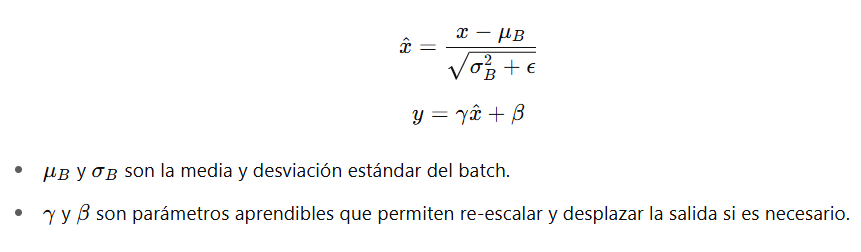

# ¿Qué hace este código?
El código define una capa personalizada de Batch Normalization condicional, conocida como:

🔧 ConditionalBatchNorm
Esta es una variación de BatchNormalization que modula la salida según una condición externa (por ejemplo, una clase o dominio). Se usa en arquitecturas como GANs condicionales, style transfer, y otras tareas donde la red debe comportarse diferente según una entrada auxiliar.

🔍 Desglose del código:
```python

class ConditionalBatchNorm(layers.Layer):
    def __init__(self, num_features, num_conditions):
        super().__init__()
        self.bn = layers.BatchNormalization(center=False, scale=False)
```
Se crea una capa BatchNormalization, pero sin gamma ni beta aprendibles, porque se van a generar desde embeddings según una condición externa.

```python
        self.gamma = layers.Embedding(num_conditions, num_features, embeddings_initializer='ones')
        self.beta = layers.Embedding(num_conditions, num_features, embeddings_initializer='zeros')
```
En lugar de usar parámetros fijos para todos los ejemplos, se usa una tabla de embeddings que mapea cada condición a un vector gamma y beta diferente.

```python
    def call(self, x, condition):
        normalized = self.bn(x)
```
Normaliza x usando BatchNorm (solo con media y varianza).

```python
        gamma = self.gamma(condition)[:, tf.newaxis, tf.newaxis, :]
        beta = self.beta(condition)[:, tf.newaxis, tf.newaxis, :]
```
Extrae el gamma y beta correspondientes a cada condición y les da forma para poder ser aplicados broadcasted al x (asumiendo que x es 4D: [batch, height, width, channels]).

```python
        return gamma * normalized + beta
```
Aplica el escalado y desplazamiento condicional.

📌 Ejemplo de uso
Imaginá que tenés una red generativa que genera imágenes de perros o gatos. La condition sería 0 para "perro", 1 para "gato". La capa aprende cómo normalizar de forma distinta según lo que se quiere generar.

✅ ¿Cuándo usar ConditionalBatchNorm?
En redes condicionales (Cond-GANs, StyleGAN, Conditional VAE).

En aprendizaje multitarea o multiclase donde se necesita adaptar el comportamiento de la red según una señal externa.

En visión por computadora cuando distintos dominios tienen estadísticas distintas (por ejemplo, estilos artísticos distintos).

## ¿Que es un embeding?

Un embedding es una representación numérica (vector) densa y de menor dimensión de datos categóricos o discretos, como palabras, clases o etiquetas. En lugar de usar representaciones simples como one-hot encoding, los embeddings permiten que estos datos sean representados en un espacio continuo donde se capturan relaciones semánticas o estructurales entre ellos.

🎯 Ejemplo simple: categorías a vectores
Supongamos que tenemos 3 clases:

css
Copiar
['gato', 'perro', 'conejo']
🔹 One-hot encoding
css
Copiar
gato   → [1, 0, 0]
perro  → [0, 1, 0]
conejo → [0, 0, 1]
Tiene dimensión 3

Es esparso: muchos ceros

No codifica ninguna relación entre categorías

🔹 Embedding (por ejemplo, de dimensión 2)
css
Copiar
gato   → [ 0.2, -0.1]
perro  → [ 0.3, -0.2]
conejo → [-0.5,  0.7]
Tiene dimensión más baja (más eficiente)

Es denso (valores continuos)

Se puede aprender durante el entrenamiento

📦 En TensorFlow / Keras:
python
Copiar
tf.keras.layers.Embedding(input_dim=3, output_dim=2)
Esto crea una tabla de embeddings de forma (3, 2) que se comporta como una "lookup table": si le das el índice 1, te devuelve el vector [0.3, -0.2].

🧠 ¿Dónde se usa?
Área	¿Qué representa el embedding?
Procesamiento de texto	Palabras o tokens
Sistemas de recomendación	IDs de usuarios, productos
Redes condicionales	Clases, condiciones, dominios
Juegos / Ajedrez / RL	Estados o acciones codificadas
Tu código (ConditionalBatchNorm)	La clase/condición para modulación de parámetros

⚙️ ¿Por qué son tan útiles?
Reducen dimensionalidad

Permiten que el modelo aprenda relaciones entre elementos

Se entrenan como cualquier otro peso de la red (con backpropagation)

Pueden generalizar a nuevas combinaciones o patrones



## Original pure CNN architecture:¶
this version used a convultional network with a kernel size of 3 to learn the position's features. IN theory, useful for local features identification like pawn chains and structures, but can't make sense of long range relationships like threats, pins and attacks ..

In [8]:
    # Model Architecture
class ChessEvaluationCNN(Model):
    def __init__(self, num_piece_channels=13, num_classes=1, num_conditions=2):
        super(ChessEvaluationCNN, self).__init__()
        
        # Convolutional layers
        self.conv1 = layers.Conv2D(64, kernel_size=3, padding='same')
        self.cbn1 = ConditionalBatchNorm(64, num_conditions)
        self.conv2 = layers.Conv2D(128, kernel_size=3, padding='same')
        self.cbn2 = ConditionalBatchNorm(128, num_conditions)
        self.conv3 = layers.Conv2D(256, kernel_size=3, padding='same')
        self.cbn3 = ConditionalBatchNorm(256, num_conditions)
        
        # Fully connected layers
        self.flatten = layers.Flatten()
        self.fc1 = layers.Dense(1024, activation='relu')
        self.fc2 = layers.Dense(num_classes)

    def call(self, inputs):
        board_tensor, active_player, halfmove_clock = inputs

        # Forward pass
        x = self.conv1(board_tensor)
        x = self.cbn1(x, active_player)
        x = tf.nn.relu(x)

        x = self.conv2(x)
        x = self.cbn2(x, active_player)
        x = tf.nn.relu(x)

        x = self.conv3(x)
        x = self.cbn3(x, active_player)
        x = tf.nn.relu(x)
        
        # Global average pooling
        x = tf.reduce_mean(x, axis=[1, 2])  # (batch_size, 256)
        
        # Fully connected layer with halfmove clock
        x = tf.concat([self.fc1(x), tf.expand_dims(halfmove_clock, -1)], axis=1)
        output = self.fc2(x)
        
        return output

## CNN + VIT
Using a hybrid architecture consisting of convolutional network + vision transformer with the added benefit of self attention, giving the model the ability to learn long range piece relationships, highly scalable.

In [10]:
# Helper function to create patches for ViT
def create_patches(x, patch_size):
    # Dynamically get batch size and input dimensions
    batch_size = tf.shape(x)[0]  # Dynamically fetch the actual batch size at runtime
    channels = x.shape[1]  # Channels are known statically (13)
    height = x.shape[2]     # Known statically (8)
    width = x.shape[3]      # Known statically (8)

    # Ensure the input is in the expected shape
    if height != 8 or width != 8:
        raise ValueError("Input dimensions for chessboard must be (None, 13, 8, 8)")

    # Reshape the input tensor to create patches
    patches = tf.image.extract_patches(
        images=tf.transpose(x, [0, 2, 3, 1]),  
        sizes=[1, patch_size, patch_size, 1],
        strides=[1, patch_size, patch_size, 1],
        rates=[1, 1, 1, 1],
        padding='VALID'
    )

    # Reshape the patches into (batch_size, num_patches, patch_dim)
    patch_dim = patch_size * patch_size * channels 
    num_patches = (height // patch_size) * (width // patch_size)
    
    # Use static shape where possible to avoid runtime errors during XLA compilation
    patches = tf.reshape(patches, [-1, num_patches, patch_dim])  # Use -1 for dynamic batch_size

    return patches

class ViTBlock(layers.Layer):
    def __init__(self, num_heads, embed_dim, ff_dim):
        super(ViTBlock, self).__init__()
        self.attention = layers.MultiHeadAttention(num_heads=num_heads, key_dim=embed_dim)
        self.ffn = tf.keras.Sequential([
            layers.Dense(ff_dim, activation='relu'),
            layers.Dense(embed_dim)
        ])
        self.layernorm1 = layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = layers.LayerNormalization(epsilon=1e-6)

    def call(self, inputs):
        attn_output = self.attention(inputs, inputs)
        out1 = self.layernorm1(inputs + attn_output)
        ffn_output = self.ffn(out1)
        out2 = self.layernorm2(out1 + ffn_output)
        return out2

# Hybrid model definition (CNN + ViT)
from keras.saving import register_keras_serializable

@register_keras_serializable(package="ChessModel")
class ChessEvaluationHybridModel(Model):
    def __init__(self, num_piece_channels=13, num_classes=1, num_conditions=2, patch_size=2):
        super(ChessEvaluationHybridModel, self).__init__()
        
        self.num_piece_channels=num_piece_channels
        self.num_classes=num_classes
        self.num_conditions=num_conditions
        self.patch_size=patch_size
        
        # CNN layers
        self.conv1 = layers.Conv2D(64, kernel_size=3, padding='same')
        self.cbn1 = ConditionalBatchNorm(64, num_conditions)
        self.conv2 = layers.Conv2D(128, kernel_size=3, padding='same')
        self.cbn2 = ConditionalBatchNorm(128, num_conditions)
        self.conv3 = layers.Conv2D(256, kernel_size=3, padding='same')
        self.cbn3 = ConditionalBatchNorm(256, num_conditions)
        
        # ViT layers
        self.patch_size = patch_size
        self.embedding_dim = (patch_size * patch_size) * num_piece_channels
        self.vit_proj = layers.Dense(self.embedding_dim)  # Project patches into embedding space
        
        self.vit_block1 = ViTBlock(num_heads=4, embed_dim=self.embedding_dim, ff_dim=512)
        self.vit_block2 = ViTBlock(num_heads=4, embed_dim=self.embedding_dim, ff_dim=512)
        
        self.flatten = layers.Flatten()
        
        # Fully connected layers
        self.fc1 = layers.Dense(1024, activation='relu')
        self.fc2 = layers.Dense(num_classes)

    def call(self, inputs):
        board_tensor, active_player, halfmove_clock = inputs

        # CNN forward pass
        x = self.conv1(board_tensor)
        x = self.cbn1(x, active_player)
        x = tf.nn.relu(x)

        x = self.conv2(x)
        x = self.cbn2(x, active_player)
        x = tf.nn.relu(x)

        x = self.conv3(x)
        x = self.cbn3(x, active_player)
        x = tf.nn.relu(x)
        
        # ViT forward pass
        patches = create_patches(board_tensor, self.patch_size)
        patches = self.vit_proj(patches)
        vit_out = self.vit_block1(patches)
        vit_out = self.vit_block2(vit_out)
        vit_out = tf.reduce_mean(vit_out, axis=1)  # Global average pooling for patches

        # Combine CNN and ViT outputs
        x = tf.concat([self.flatten(x), vit_out], axis=1)
        
        # Fully connected layers with halfmove clock
        x = tf.concat([self.fc1(x), tf.expand_dims(halfmove_clock, -1)], axis=1)
        output = self.fc2(x)
        
        return output
    @classmethod
    def from_config(cls, config):
        # Manually pass in the parameters here
        return cls(
            num_piece_channels=config['num_piece_channels'],
            num_classes=config['num_classes'],
            num_conditions=config['num_conditions'],
            patch_size=config['patch_size']
        )

    def get_config(self):
        config = super().get_config()
        # Include the custom arguments in the config dictionary
        config.update({
            'num_piece_channels': self.num_piece_channels,
            'num_classes': self.num_classes,
            'num_conditions': self.num_conditions,
            'patch_size': self.patch_size
        })
        return config

In [ ]:
# %pip install kaggle_secrets
#Loading previous version output using kaggle api 
!rm -rf /kaggle/working/*

#Replace with your own kaggle api as kaggle secrets input when copying this noteebook
from kaggle_secrets import UserSecretsClient
user_secrets = UserSecretsClient()
Api_key = user_secrets.get_secret("Kaggle Api")

import os
os.environ['KAGGLE_USERNAME'] = 'oussamahaboubi'
os.environ['KAGGLE_KEY'] = Api_key


def get_model():
    saved_model=None
    home_path="/kaggle/working/"
    for file in os.listdir(home_path):
        if ".keras" in file:
            saved_model=home_path+file
    return saved_model

saved_model=get_model()
if not saved_model:   
    !kaggle kernels output oussamahaboubi/chess-evaluation-cnn-tensorflow -p /kaggle/working/
    saved_model=get_model()

# from tensorflow.keras.models import load_model
# print(saved_model)

# saved_model='/kaggle/working/checkpoint211120241650.model.keras'
# model = ChessEvaluationHybridModel()
# model = tf.keras.models.load_model(saved_model,custom_objects={'ChessEvaluationHybridModel': ChessEvaluationHybridModel})

# Create model with manual config
# model = ChessEvaluationHybridModel()
# model=tf.keras.models.load_model("/kaggle/working/21-11-2024 19:51.keras")

# Now load the weights into the new model
# model.load_weights(saved_model)

ERROR: Could not find a version that satisfies the requirement kaggle_secrets (from versions: none)
ERROR: No matching distribution found for kaggle_secrets
Note: you may need to restart the kernel to use updated packages.


ModuleNotFoundError: No module named 'kaggle_secrets'